## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [60]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
                                           
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [61]:
len(fmnist_dataset_test)

10000

In [62]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [63]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape,700),
            nn.Linear(700,600),
            nn.ReLU(),
            nn.Linear(600,500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Linear(200, 120),
            nn.ELU(),
            nn.Linear(120, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [64]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
            Linear-3                  [-1, 600]         420,600
              ReLU-4                  [-1, 600]               0
            Linear-5                  [-1, 500]         300,500
              ReLU-6                  [-1, 500]               0
            Linear-7                  [-1, 200]         100,200
            Linear-8                  [-1, 120]          24,120
               ELU-9                  [-1, 120]               0
           Linear-10                   [-1, 10]           1,210
Total params: 1,396,130
Trainable params: 1,396,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.33
Estimat

Your experiments come here:

In [65]:
model = TinyNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_func = nn.CrossEntropyLoss()

In [66]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        print(f"processing {epoch} epoch")
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch.to(device)
            y_batch.to(device)

            predictions = model.forward(X_batch)
            loss = loss_func(predictions, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()


            ep_train_loss.append(loss.item())

        model.eval() # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                  X_batch.to(device)
                  y_batch.to(device)
                  predictions = model(X_batch)
                  loss = loss_func(predictions, y_batch)
                  predictions = predictions.max(dim = 1)[1]
                  ep_val_loss.append(loss)
                  accr = (predictions == y_batch).cpu().detach().numpy().mean()
                  ep_val_accuracy.append(accr)
        # print the results for this epoch:

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [67]:
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func,opt, n_epochs=13 )

processing 0 epoch
	  training loss: 0.568421
	validation loss: 0.455580
	validation accuracy: 0.833
processing 1 epoch
	  training loss: 0.399406
	validation loss: 0.414353
	validation accuracy: 0.852
processing 2 epoch
	  training loss: 0.363055
	validation loss: 0.386996
	validation accuracy: 0.862
processing 3 epoch
	  training loss: 0.340012
	validation loss: 0.367180
	validation accuracy: 0.865
processing 4 epoch
	  training loss: 0.316234
	validation loss: 0.367194
	validation accuracy: 0.871
processing 5 epoch
	  training loss: 0.297513
	validation loss: 0.366943
	validation accuracy: 0.866
processing 6 epoch
	  training loss: 0.285625
	validation loss: 0.346145
	validation accuracy: 0.878
processing 7 epoch
	  training loss: 0.273720
	validation loss: 0.355169
	validation accuracy: 0.878
processing 8 epoch
	  training loss: 0.267164
	validation loss: 0.351337
	validation accuracy: 0.874
processing 9 epoch
	  training loss: 0.256065
	validation loss: 0.351504
	validation accura

In [68]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

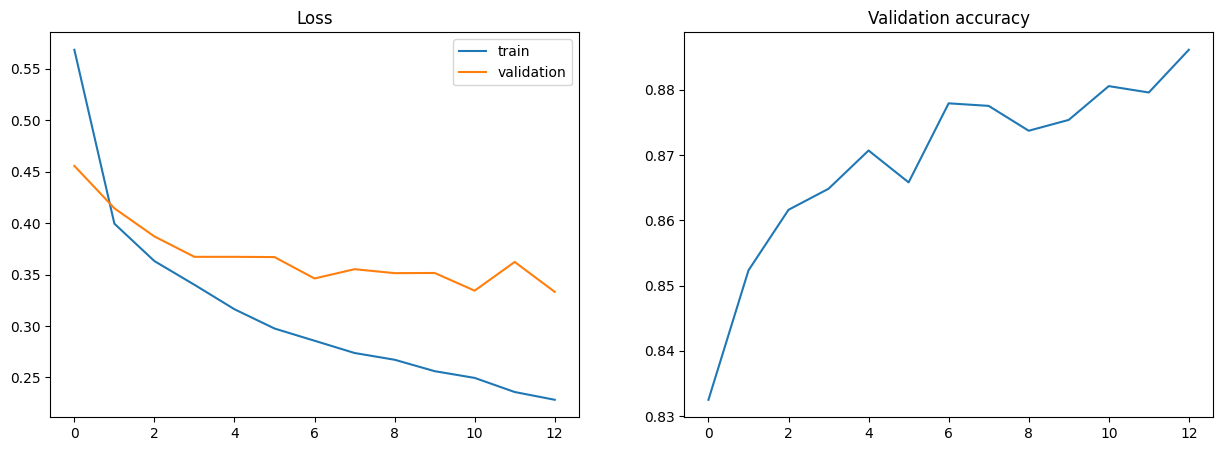

In [69]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [84]:
import torch.utils.data as data_utils


In [85]:
fmnist_dataset_train1 = fmnist_dataset_train
fmnist_dataset_train1 = data_utils.Subset(fmnist_dataset_train1, torch.arange(1,1000))
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train1, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
                                           
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [96]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape,700),
            nn.Linear(700,300),
            nn.ReLU(),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.Linear(200, 120),
            nn.ELU(),
            nn.Linear(120, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [97]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
            Linear-3                  [-1, 300]         210,300
              ReLU-4                  [-1, 300]               0
            Linear-5                  [-1, 500]         150,500
              ReLU-6                  [-1, 500]               0
            Linear-7                  [-1, 300]         150,300
              ReLU-8                  [-1, 300]               0
            Linear-9                  [-1, 200]          60,200
           Linear-10                  [-1, 120]          24,120
              ELU-11                  [-1, 120]               0
           Linear-12                   [-1, 10]           1,210
Total params: 1,146,130
Trainable params: 1,146,130
Non-trainable params: 0
---------------------------

In [98]:
model = OverfittingNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_func = nn.CrossEntropyLoss()

In [99]:
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs=30 )

processing 0 epoch
	  training loss: 2.097797
	validation loss: 1.550758
	validation accuracy: 0.340
processing 1 epoch
	  training loss: 1.353555
	validation loss: 1.167533
	validation accuracy: 0.519
processing 2 epoch
	  training loss: 1.051420
	validation loss: 1.041440
	validation accuracy: 0.561
processing 3 epoch
	  training loss: 0.892909
	validation loss: 0.887678
	validation accuracy: 0.649
processing 4 epoch
	  training loss: 0.845502
	validation loss: 0.822066
	validation accuracy: 0.704
processing 5 epoch
	  training loss: 0.788711
	validation loss: 0.847261
	validation accuracy: 0.675
processing 6 epoch
	  training loss: 0.726189
	validation loss: 0.826257
	validation accuracy: 0.685
processing 7 epoch
	  training loss: 0.673434
	validation loss: 0.775827
	validation accuracy: 0.713
processing 8 epoch
	  training loss: 0.611180
	validation loss: 0.723039
	validation accuracy: 0.743
processing 9 epoch
	  training loss: 0.542064
	validation loss: 0.788233
	validation accura

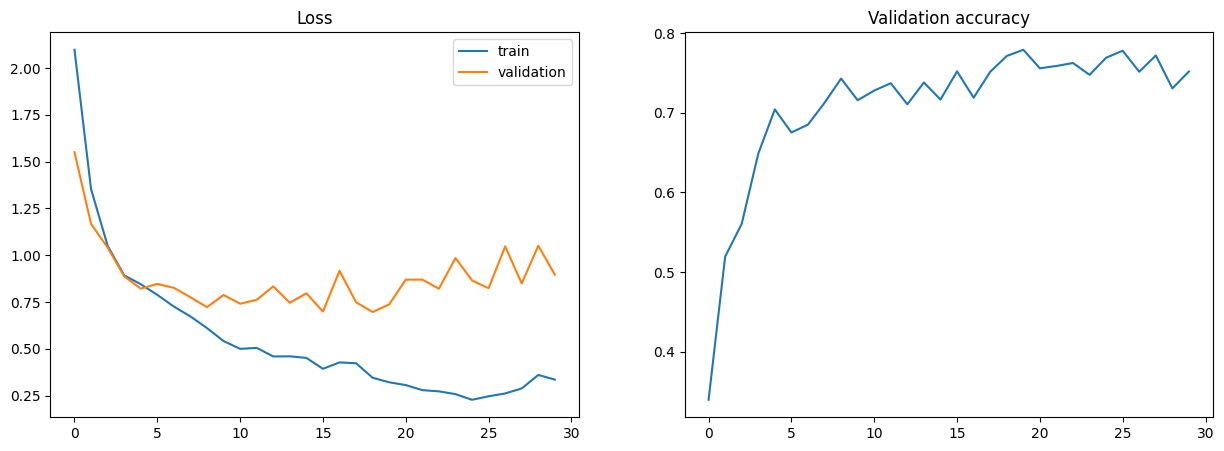

In [101]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [161]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Dropout(p = 0.25),
            nn.Linear(input_shape,700),
            nn.Dropout(p = 0.25),
            nn.Linear(700,300),
            nn.ReLU(),
            nn.Dropout(p = 0.25),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.Linear(200, 120),
            nn.ELU(),
            nn.Linear(120, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [162]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 700]         549,500
           Dropout-4                  [-1, 700]               0
            Linear-5                  [-1, 300]         210,300
              ReLU-6                  [-1, 300]               0
           Dropout-7                  [-1, 300]               0
            Linear-8                  [-1, 500]         150,500
              ReLU-9                  [-1, 500]               0
           Linear-10                  [-1, 300]         150,300
             ReLU-11                  [-1, 300]               0
           Linear-12                  [-1, 200]          60,200
           Linear-13                  [-1, 120]          24,120
              ELU-14                  [

In [163]:
fmnist_dataset_train1 = fmnist_dataset_train
fmnist_dataset_train1 = data_utils.Subset(fmnist_dataset_train1, torch.arange(1,1000))
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train1, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
                                           
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [164]:
model = FixedNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs=30 )


processing 0 epoch
	  training loss: 2.095121
	validation loss: 1.659880
	validation accuracy: 0.308
processing 1 epoch
	  training loss: 1.399759
	validation loss: 1.140643
	validation accuracy: 0.504
processing 2 epoch
	  training loss: 1.102556
	validation loss: 1.020862
	validation accuracy: 0.553
processing 3 epoch
	  training loss: 0.986348
	validation loss: 0.900820
	validation accuracy: 0.639
processing 4 epoch
	  training loss: 0.861752
	validation loss: 0.868356
	validation accuracy: 0.659
processing 5 epoch
	  training loss: 0.791378
	validation loss: 0.816519
	validation accuracy: 0.648
processing 6 epoch
	  training loss: 0.784134
	validation loss: 0.777989
	validation accuracy: 0.706
processing 7 epoch
	  training loss: 0.700605
	validation loss: 0.726962
	validation accuracy: 0.731
processing 8 epoch
	  training loss: 0.627349
	validation loss: 0.710633
	validation accuracy: 0.744
processing 9 epoch
	  training loss: 0.628669
	validation loss: 0.713817
	validation accura

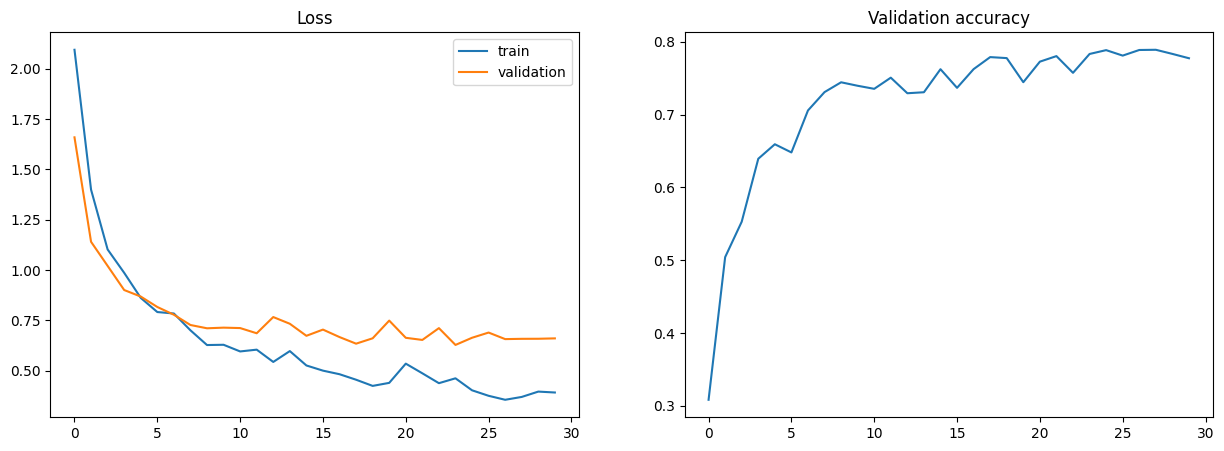

In [166]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._
Dropout is s really cool techique for fighting with overfitting. I was not in a good terms with batchnorm from the beginning, it caused only bigger overfitting in the end :(. The overfitting comes with in a huge amouth of epoched and a complicated structure of a neural network.